# IE4424 Lab Time_Series_Prediction_Optional

## Acknowledgment

This lab experiment is inspired by Usman Malik's Stack Abuse article.

You can check out the original post at https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python



## 1. Training a time series predictor

A time series data is a sequential data indexed in time order.
Often we would like to predict the future behaviour of a time series.
For example, we may be interested in predicting the weather, share prices, sales, etc. 
Long Short-Term Memory (LSTM) model can be applied to perform time series prediction. 

In this exercise, we will use the ``flights`` dataset from the seaborn library.
The dataset contains 3 columns: ``year``, ``month``, and ``passengers``.
Where the ``year`` and ``month`` columns refer to the particular year and month of the monthly flight record, respectively.
The ``passengers`` column records the total number of passengers that took the flights in that month.

We will do the following steps in order:

1) Load and normalize the training and testing datasets using ``StandardScalar``
   
2) Define an LSTM model

3) Define a loss function

4) Train the network on the training data

5) Test the network on the test data

In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### 1. Loading the flights dataset


Loading the ``flights`` data from ``seaborn`` is strightforward.

In [3]:
import seaborn as sns

flights = sns.load_dataset('flights')
print(type(flights)) # the dataset is loaded as pandas dataframe
flights.describe(include = 'all')

# save the data as comma-separated values (csv) to facilitate viewing of the raw data
# flights.to_csv('flights_data.csv', index=False)

<class 'pandas.core.frame.DataFrame'>


,year,month,passengers
count,144.000000,144,144.000000
unique,NaN,12,NaN
top,NaN,Jan,NaN
freq,NaN,12,NaN
mean,1954.500000,NaN,280.298611
std,3.464102,NaN,119.966317
min,1949.000000,NaN,104.000000
25%,1951.750000,NaN,180.000000
50%,1954.500000,NaN,265.500000
75%,1957.250000,NaN,360.500000



### 2. Visualizing the training data


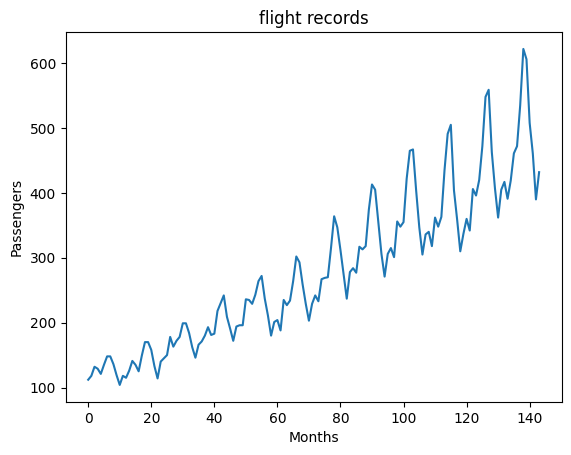

In [4]:
plt.plot(flights['passengers'])
plt.title('flight records')
plt.xlabel('Months')
plt.ylabel('Passengers')
plt.show()

### 3. Normalizing the data and converting to tensor

In a regression problem such as this, it is beneficial to normalize the data. It allows the model to converge faster and avoid having large losses. 

In [5]:
from sklearn.preprocessing import StandardScaler

passengers = flights['passengers'].values.astype(float) # convert the passengers column to float 
scaler = StandardScaler()
normalized_data = scaler.fit_transform(passengers.reshape(-1,1))

### 4. Generating the sequences
Since we have 144 months (i.e., 12 years) of flight data, we use 132 months (i.e., 11 years) for training and the remaining 12 months (i.e., 1 year) for testing.

In [6]:
# create windowed sequence tuples of (x,y), with moving window of step size = 1
def windowed_sequences(data, window_size=12, test_size=12):
    x = []
    y = []
    for i in range(len(data)-window_size-test_size+1):
        j = i + window_size
        xi = data[i:j]
        yi = data[j]
        x.append(xi)
        y.append(yi)
    return x, y
        
test_size = 12
seqeunces, targets = windowed_sequences(normalized_data, 12, test_size)

 # Convert the sequences to float type tensors
train_x = torch.Tensor(seqeunces[:-1]).type(torch.float)
train_y = torch.Tensor(targets[:-1]).type(torch.float) 
test_seq = torch.Tensor(seqeunces[-1]).type(torch.float)

C:\Users\wilso\AppData\Local\Temp\ipykernel_17016\2599777276.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  train_x = torch.Tensor(seqeunces[:-1]).type(torch.float)


### 5. Constructing the iterables

In [7]:
# Using pytorch data loading utility to construct iterable over the dataset

from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, x, y):
        super(CustomDataset, self).__init__()
        self.x = x
        self.y = y

    def __getitem__(self, item):
        return self.x[item],  self.y[item]

    def __len__(self):
        return len(self.x)
    
train_set = CustomDataset(train_x, train_y)
train_loader = DataLoader(train_set, batch_size=24)

## Optional Exercise

So far we have considered different configurations for a single LSTM layer. 

Similar to the CNN, additional layers can be added to the LSTM to make the model deeper and adding levels of abstraction. This is achieved by stacking multilayers of LSTM on top of each other. 

In addition, on some sequential data problems, having the LSTM model learn the input sequences from both forward and backward directions can be beneficial. The backward direction LSTM processes the input in reverse chronological order. To consider both forward and backward information the hidden states from both directions are concatenated.

In this part, you will modify the network into a bidirectional multilayer LSTM.
Pytorch LSTM module has provided a convenient wrapper to facilitate the construction of bidirectional and multilayer LSTM: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
Note that the hidden states of the LSTM module may change according to the configurations (i.e., bidirectional would double the hidden state size at each layer). Tune the model to find the most suitable hyperparameters for your bidirectional multilayer LSTM.

### 6. Defining the bidirectional multilayer LSTM model (To do)

In [8]:
class TimeSeriesPredictor(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=200, output_dim=1, num_layers=1):
        super(TimeSeriesPredictor,self).__init__()
        
        self.hidden_dim = hidden_dim
        
        # To do
        self.lstm = nn.LSTM(input_dim, self.hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(self.hidden_dim*2, 100)
        self.fc2 = nn.Linear(100, output_dim)

    def forward(self, input_seq):

        lstm_out, (hn, cn) = self.lstm(input_seq)
        
        # Concatenate the hidden states from the last layer for both directions
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim=1)
        predictions = F.relu(self.fc1(hn))
        predictions = self.fc2(predictions)
        return predictions

### 7. Initializing the network and optimizer

In [9]:
model = TimeSeriesPredictor(num_layers=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001) # adapt to increased model complexity by lowering lr

### 8. Print the network structure

In [10]:
print(model)

TimeSeriesPredictor(
  (lstm): LSTM(1, 200, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=400, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
)


### 9. Initialize the training iterables

In [11]:
window_size = 12
test_size = 12
seqeunces, targets = windowed_sequences(normalized_data, window_size, test_size)
train_x = torch.Tensor(seqeunces[:-1]).type(torch.float)
train_y = torch.Tensor(targets[:-1]).type(torch.float)
test_seq = torch.Tensor(seqeunces[-1]).type(torch.float)

train_set = CustomDataset(train_x, train_y)
train_loader = DataLoader(train_set, batch_size=12) # Reduce batch_size to prevent out of memory
test_seq = torch.Tensor(seqeunces[-1]).type(torch.float)

### 10. Training the network

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#2024 modification CPU > GPU
model.to(device)#2024 modification CPU > GPU
t1 = time.time()
loss_list = []
for epoch in range(1000):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        seq, labels = data
        seq, labels = seq.to(device), labels.to(device)#2024 modification CPU > GPU
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    loss_list.append(running_loss/len(train_loader))
    if epoch % 100 == 99:
        print(f'epoch: {epoch+1:3} loss: {running_loss/len(train_loader):.4f}')

t2 = time.time()
print('Finished Training')
print('Training time:'+str(t2-t1))

epoch: 100 loss: 0.1374
epoch: 200 loss: 0.1223
epoch: 300 loss: 0.1014
epoch: 400 loss: 0.0752
epoch: 500 loss: 0.0466
epoch: 600 loss: 0.0273
epoch: 700 loss: 0.0220
epoch: 800 loss: 0.0195
epoch: 900 loss: 0.0181
epoch: 1000 loss: 0.0172
Finished Training
Training time:191.8724672794342


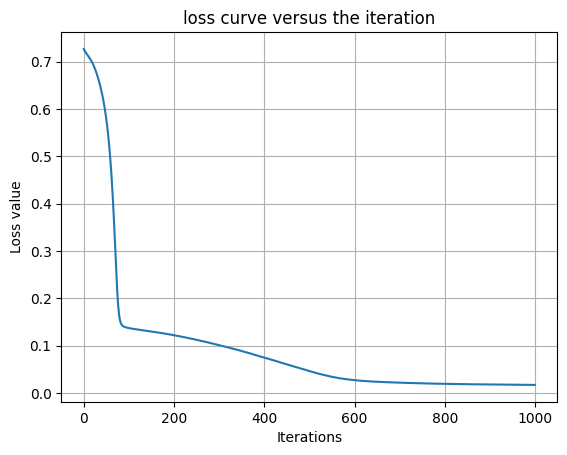

In [13]:
iterations = np.arange(len(loss_list))

fig, ax = plt.subplots()
ax.plot(iterations, loss_list)
ax.set(xlabel='Iterations', ylabel='Loss value',
       title='loss curve versus the iteration')
ax.grid()

plt.show()

### 11. Perform predictions

In [14]:
preds_bdml = []
with torch.no_grad():
    for i in range(test_size):
        outputs = model(test_seq.unsqueeze(dim=0)) # unsqueeze to add a dimension to accomodate the batch processing
        test_seq = torch.cat((test_seq,outputs),dim=0)[-12:]
        preds_bdml.append(outputs)

### 12. Evaluate performance

In [15]:
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# Move each tensor in preds_bdml to CPU and convert to numpy, then reshape
denormalized_preds_bdml = np.array([output.cpu().numpy() for output in preds_bdml]).reshape(-1, 1)#2024 modification CPU > GPU

# Apply inverse transformation using the scaler
denormalized_preds_bdml = scaler.inverse_transform(denormalized_preds_bdml)#2024 modification CPU > GPU

# Calculate MAPE
mape = mean_absolute_percentage_error(passengers[-test_size:], denormalized_preds_bdml)

# Print the MAPE as percentage
print('MAPE: %.2f%%' % (mape * 100))

MAPE: 4.31%


### 13. Plotting the results in the same plot (To do)

Plot the the ground truth (in black and label it as 'ground truth') and the bidirectional multilayer LSTM prediction (in green dotted line with x marker and label it as 'bdml').

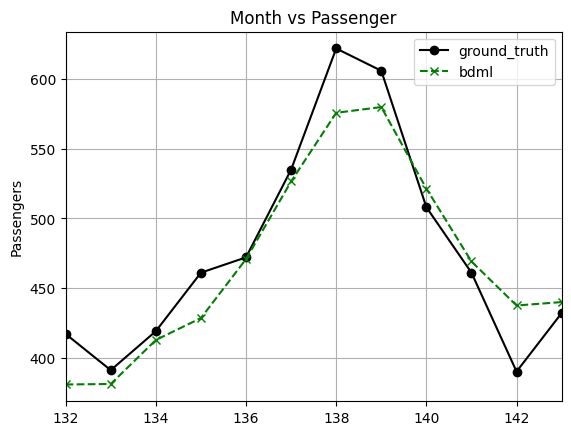

In [16]:
# To do 
x_axis = np.arange(132, 144, 1)
plt.title('Month vs Passenger')
plt.ylabel('Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(x_axis,passengers[-test_size:], 'ko-', label='ground_truth')
plt.plot(x_axis,denormalized_preds_bdml, 'gx--', label='bdml')
plt.legend()
plt.show()